In [22]:
from __future__ import print_function    # (at top of module)
import warnings
#warnings.filterwarnings('always')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.pyplot import figure
import math
import seaborn as sns
import io, os, sys, types

In [23]:
# Read the data from the file
data = pd.read_csv('data_500_entries_youtube.csv')
print("Number of entries in original data: " + str(len(data.index)))
data.head()

Number of entries in original data: 570


,song_id,song_title,artist,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,youtube_video_title
0,spotify:track:5ygDXis42ncn6kYG14lEVG,Baby Shark,[Pinkfong],77,0.840,0.3410,115.062,0.2270,0.2450,0.000000,4,0.825,7,96333,-3.651,0.520,1,1956582159,Baby Shark Dance | Sing and Dance! | Animal So...
1,spotify:track:7fa9MBXhVfQ8P8Df9OEbD8,Girls Like You (feat. Cardi B),"[Maroon 5, Cardi B]",86,0.541,0.1300,124.959,0.0505,0.5680,0.000000,4,0.851,0,235545,-6.825,0.448,1,1300452389,Maroon 5 - Girls Like You ft. Cardi B
2,spotify:track:6De0lHrwBfPfrhorm9q1Xl,Me Rehúso,[Danny Ocean],83,0.804,0.0494,104.823,0.0677,0.0231,0.000000,4,0.744,1,205715,-6.327,0.426,1,1229501096,Danny Ocean - Me Rehúso (Official Audio)
3,spotify:track:1j6xOGusnyXq3l6IryKF3G,Déjala Que Vuelva (feat. Manuel Turizo),"[Piso 21, Manuel Turizo]",74,0.788,0.0753,170.019,0.0785,0.0482,0.000000,4,0.681,1,220117,-4.323,0.839,1,1216075058,Piso 21 - Déjala Que Vuelva (feat. Manuel Turi...
4,spotify:track:2ijef6ni2amuunRoKTlgww,Sin Pijama,"[Becky G, Natti Natasha]",90,0.745,0.1040,94.014,0.0464,0.3540,0.000029,4,0.791,11,188560,-3.695,0.820,0,1071141995,Becky G Natti Natasha - Sin Pijama (Video Ofic...


In [24]:
if 'song_id' in data.columns:
    data = data.drop_duplicates(subset=['song_id'], keep='first')
else:
    data = data.drop_duplicates(subset=['song_title'], keep='first')
    
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [25]:
data = data[data.popularity > 50]
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [26]:
from project_modules import *

final_data = label_data(data, 90)

Number of popular examples after thresholding :  47
Number of not popular examples after thresholding :  523


In [27]:
# Drop unnecessary columns from original data - also some legacy support for a different data format
if 'song_id' in data.columns:
    final_data.drop(['song_id', 'song_title', 'artist', 'popularity', 'youtube_video_title'], 1, inplace=True)
else:
    final_data.drop(['song_title', 'artist', 'popularity'], 1, inplace=True) 

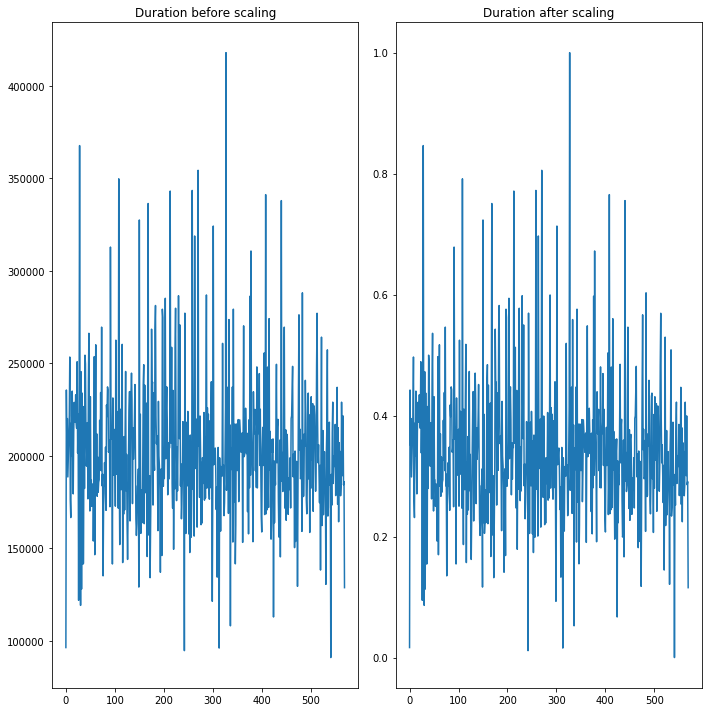

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,is_popular
0,0.838293,0.331118,0.360693,0.399286,0.247690,0.000000,0.75,0.789030,0.636364,0.016514,0.807462,0.522258,1.0,1.000000,0
1,0.502527,0.111965,0.431906,0.049366,0.574298,0.000000,0.75,0.825598,0.000000,0.442256,0.594084,0.444083,1.0,0.664655,0
2,0.797866,0.028251,0.287019,0.083466,0.023312,0.000000,0.75,0.675105,0.090909,0.351029,0.627563,0.420195,1.0,0.628392,0
3,0.779899,0.055152,0.756132,0.104877,0.048692,0.000000,0.75,0.586498,0.090909,0.395074,0.762286,0.868621,1.0,0.621530,0
4,0.731611,0.084961,0.209243,0.041237,0.357908,0.000032,0.75,0.741210,1.000000,0.298565,0.804504,0.847991,0.0,0.547456,0


In [28]:
COLUMNS_TO_SCALE = ["energy", "liveness", "tempo", 
                    "speechiness", "acousticness", "instrumentalness", 
                    "time_signature", "danceability", "key", 
                    "duration", "loudness", "valence", "mode", "youtube_view_count"]

# Keep data in a temp variable for testing
scaled_data = scale_data_normalize(final_data, COLUMNS_TO_SCALE)

# Plots to see the difference before/after scaling
plt.subplot(1,2,1)
plt.plot(data['duration'])
plt.title("Duration before scaling")

plt.subplot(1,2,2)
plt.plot(scaled_data['duration'])
plt.title("Duration after scaling")
plt.tight_layout()
plt.show()

# Copy data back
final_data = scaled_data.copy()

#Just to check that everything is fine
final_data.head()

In [29]:
# X will be our examples and y will be our labels
X = final_data.drop('is_popular', axis=1)
y = final_data['is_popular']
# Sanity checks
print("Number of entries in actual data: " + str(len(X.index)))
print("Number of entries in label data: " + str(len(y.index)))

Number of entries in actual data: 570
Number of entries in label data: 570


In [30]:
# We split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)
print("Items in training data set : ", str(len(X_train.index)))
print("Items in testing data set: ", str(len(X_test.index)))

Items in training data set :  285
Items in testing data set:  285


In [34]:
models = [
          {'title':"Logistic regression", 'model':LogisticRegression(random_state=3)},
          {'title':"Logistic regression balanced weights", 'model':LogisticRegression(class_weight='balanced', random_state=3)},
          {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(random_state=3))},
          {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(class_weight='balanced',random_state=3))},
          {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17)},
          {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 17))},
         ]

Logistic regression

Accuracy:  0.940350877193

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       268
           1       0.00      0.00      0.00        17

   micro avg       0.94      0.94      0.94       285
   macro avg       0.47      0.50      0.48       285
weighted avg       0.88      0.94      0.91       285

Confusion matrix: 
[[268   0]
 [ 17   0]]


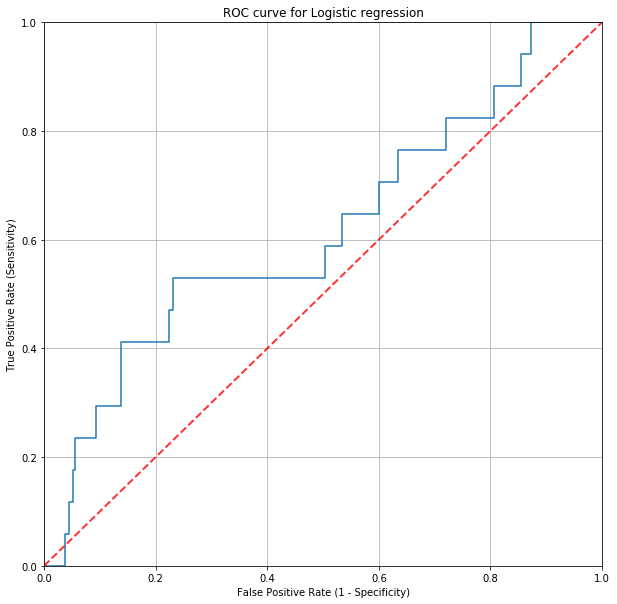

AUC score:  0.615232660228

Logistic regression balanced weights

Accuracy:  0.712280701754

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       268
           1       0.10      0.47      0.16        17

   micro avg       0.71      0.71      0.71       285
   macro avg       0.53      0.60      0.49       285
weighted avg       0.90      0.71      0.79       285

Confusion matrix: 
[[195  73]
 [  9   8]]


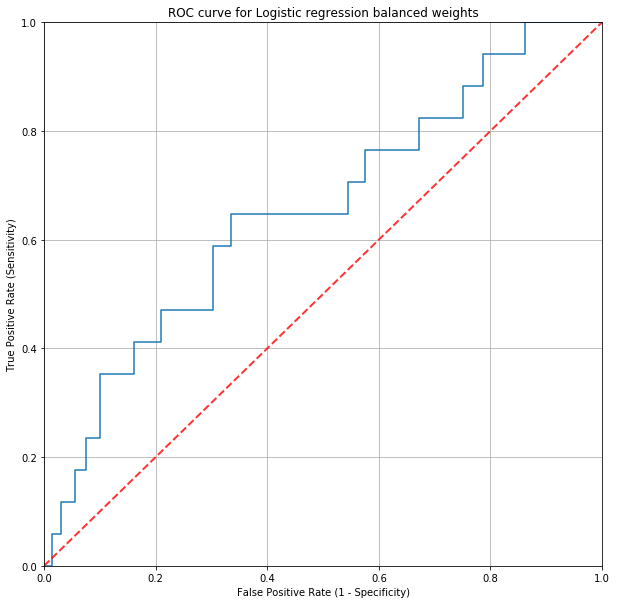

AUC score:  0.654302019315

Oversampling logistic regression

Accuracy:  0.722807017544

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       268
           1       0.09      0.41      0.15        17

   micro avg       0.72      0.72      0.72       285
   macro avg       0.52      0.58      0.49       285
weighted avg       0.90      0.72      0.79       285

Confusion matrix: 
[[199  69]
 [ 10   7]]


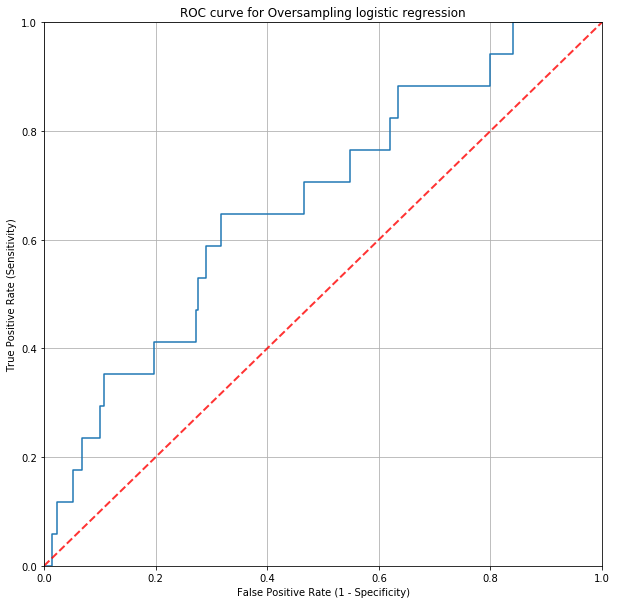

AUC score:  0.669007901668

Oversampling logistic regression balanced weights

Accuracy:  0.722807017544

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       268
           1       0.09      0.41      0.15        17

   micro avg       0.72      0.72      0.72       285
   macro avg       0.52      0.58      0.49       285
weighted avg       0.90      0.72      0.79       285

Confusion matrix: 
[[199  69]
 [ 10   7]]


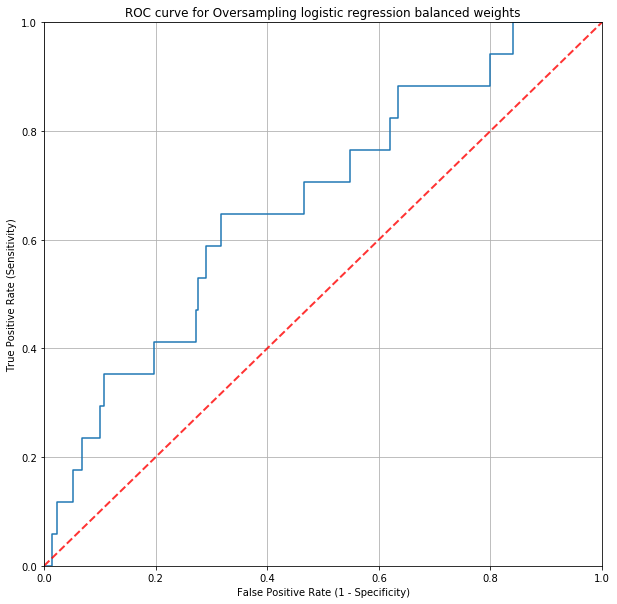

AUC score:  0.669007901668

KNN

Accuracy:  0.940350877193

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       268
           1       0.00      0.00      0.00        17

   micro avg       0.94      0.94      0.94       285
   macro avg       0.47      0.50      0.48       285
weighted avg       0.88      0.94      0.91       285

Confusion matrix: 
[[268   0]
 [ 17   0]]


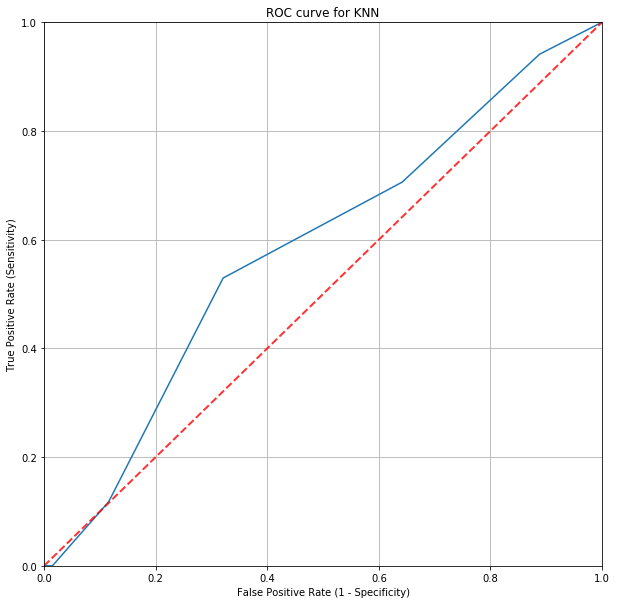

AUC score:  0.581979806848

Oversampling KNN

Accuracy:  0.40701754386

              precision    recall  f1-score   support

           0       0.96      0.38      0.55       268
           1       0.07      0.76      0.13        17

   micro avg       0.41      0.41      0.41       285
   macro avg       0.52      0.57      0.34       285
weighted avg       0.91      0.41      0.52       285

Confusion matrix: 
[[103 165]
 [  4  13]]


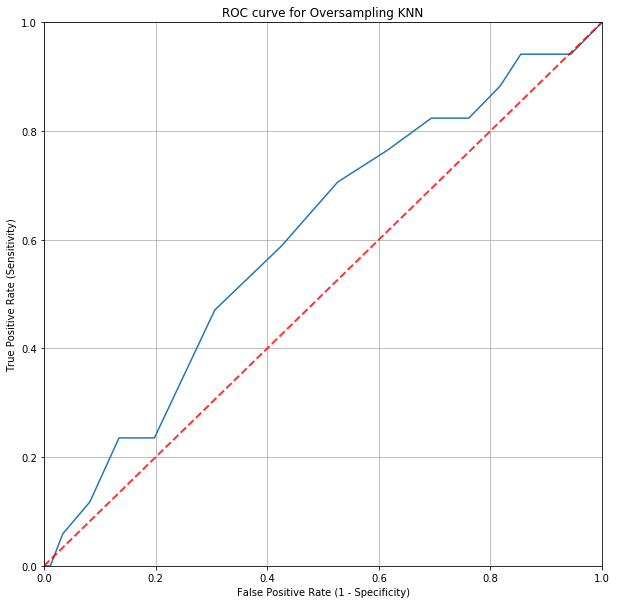

AUC score:  0.599429323968



In [35]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

for item in models:
    # Train-test split
    print(item['title'])
    
    # Train the model
    item['model'].fit(X_train, y_train)

    # Classifiy test examples
    predictions = item['model'].predict(X_test)
    print()

    # Print the accuracy score of the model
    
    print("Accuracy: ",accuracy_score(y_test, predictions))

    print()

    # Print the classification report of the model
    
    print(classification_report(y_test, predictions))

    # Print the confusion matrix
    
    print("Confusion matrix: ")
    print(confusion_matrix(y_test, predictions))

    # ROC curve
    y_pred_prob = item['model'].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.plot([0,0],[1,1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    plt.title('ROC curve for ' + item['title'])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()

    # AUC score
    print("AUC score: ", roc_auc_score(y_test, y_pred_prob))
    print()

Logistic regression


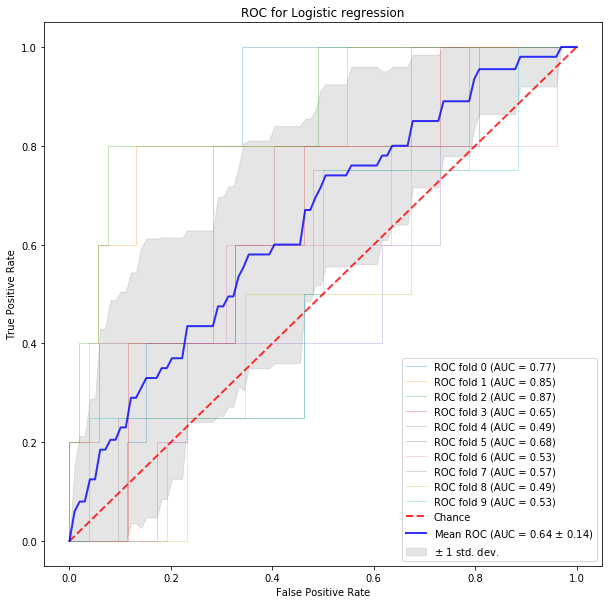

Accuracy mean:  0.917621640308

Logistic regression balanced weights


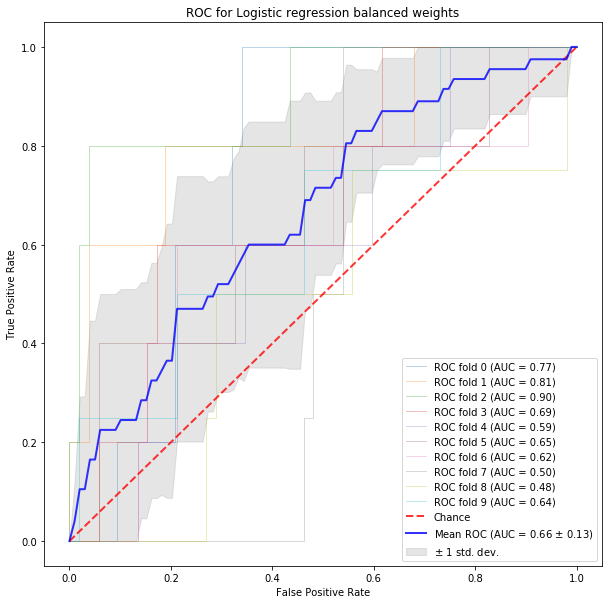

Accuracy mean:  0.651178593034

Oversampling logistic regression


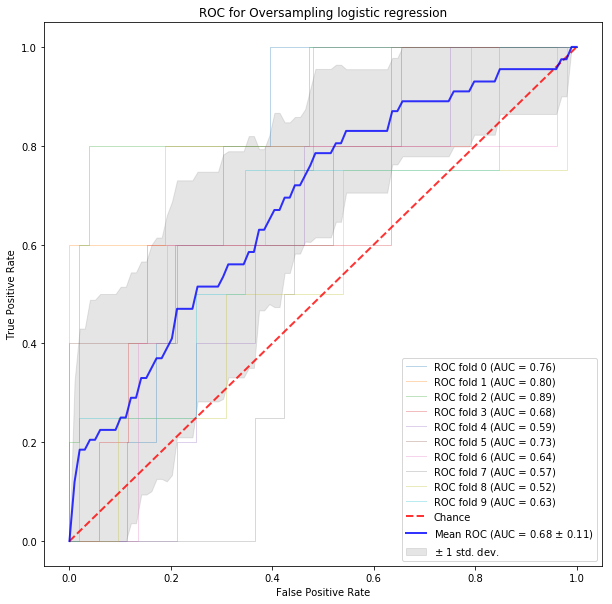

Accuracy mean:  0.665340074324

Oversampling logistic regression balanced weights


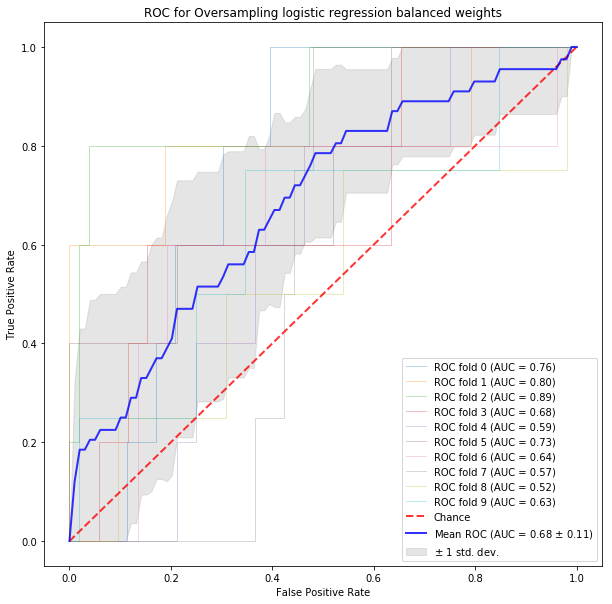

Accuracy mean:  0.665340074324

KNN


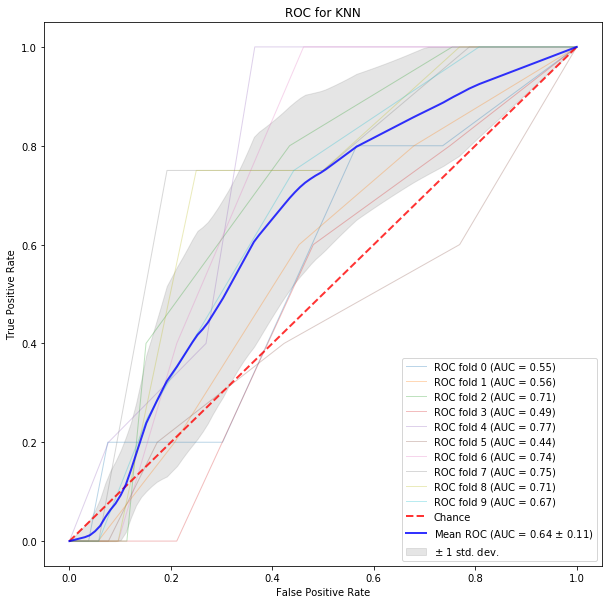

Accuracy mean:  0.917621640308

Oversampling KNN


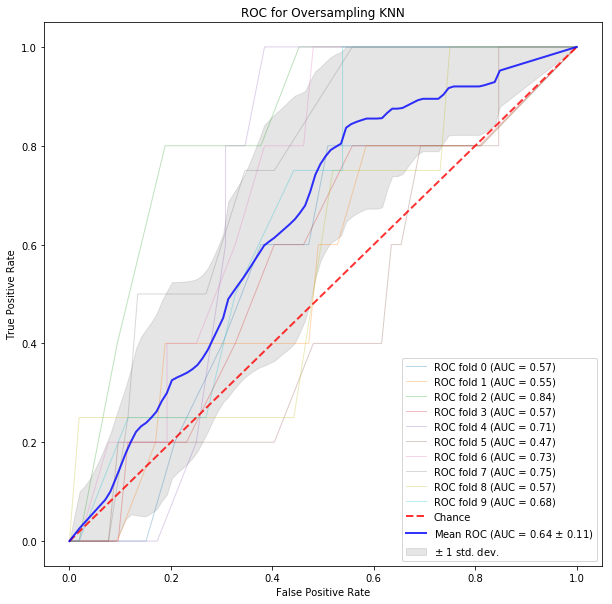

Accuracy mean:  0.524222193415



In [36]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
X = np.array(X)
y = np.array(y)
cv = StratifiedKFold(n_splits=10)
for item in models:
    # Run classifier with cross-validation and plot ROC curves
    print(item['title'])
    classifier = item['model']
    tprs = []
    aucs = []
    accs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        predicts = classifier.predict(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        accs.append(accuracy_score(y[test], predicts))
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + item['title'])
    plt.legend(loc="lower right")
    plt.show()

    print("Accuracy mean: ",np.mean(accs))
    print()